In [24]:
import os
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage

from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

from typing import Sequence, Literal

In [3]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "conflict-coach-vTool"

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=.6)

In [5]:
from typing import TypedDict


class ContextState(TypedDict):
    messages: Sequence[AnyMessage] # intentionally not appending
    context: str

In [47]:
# Tools
from langchain_core.tools import tool

@tool
def ask_user_question(question: str) -> str:
    """Ask the user a question for further context, and returns their response."""
    return input("QUESTION: "+question)


names_to_tools = {"ask_user_question": ask_user_question}

In [43]:
# Nodes


def init(state: ContextState) -> ContextState:
    message_transcript = state["messages"][-1].content

    sys_msg = SystemMessage(
        content="You are a personal coach tasked with helping the user handle their conflicts. Your goal is to ultimately help the user understand the other person's perspective, and to do that your current objective is to understand the situation. You will now recieve a message with the initial context of the conversation. You can either ask a question for clarification or more context, or send the word \"DONE\"."
    )
    user_msg = HumanMessage(content=message_transcript)

    return {"messages": [sys_msg, user_msg], "context":"<EMPTY>"}


def gather_context(state: ContextState) -> ContextState:
    print(state)
    tool_llm = llm.bind_tools([ask_user_question])
    response = tool_llm.invoke(state["messages"])

    return {"messages": state["messages"]+[response]}

def followup(state: ContextState) -> ContextState:
    print("In followup",state)
    for tool_call in state["messages"][-1].tool_calls:
        print(tool_call)
    ...

def summarize(state: ContextState) -> ContextState:
    ...

In [44]:
# Conditional Edges

def has_question(state: ContextState) -> Literal["followup", "summarize"]:
    last_message = state["messages"][-1]
    assert isinstance(last_message, AIMessage), "Expected last message to be an AIMessage"

    if not last_message.tool_calls:
        return "summarize"
    else:
        return "followup"

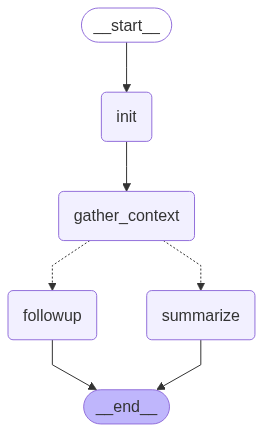

In [45]:
builder = StateGraph(ContextState)

# Add nodes to the graph
builder.add_node("init", init)
builder.add_node("gather_context", gather_context)
builder.add_node("followup", followup)
builder.add_node("summarize", summarize)

# Add edges to the graph
builder.add_edge(START, "init")
builder.add_edge("init", "gather_context")
builder.add_conditional_edges("gather_context", has_question)

react_graph = builder.compile()

# react_graph.get_graph(xray=True).print_ascii()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
messages = [HumanMessage(content="You didn't put the laundry away, you never do anything!")]
react_graph.invoke({"messages": messages})

print("done")

{'messages': [SystemMessage(content='You are a personal coach tasked with helping the user handle their conflicts. Your goal is to ultimately help the user understand the other person\'s perspective, and to do that your current objective is to understand the situation. You will now recieve a message with the initial context of the conversation. You can either ask a question for clarification or more context, or send the word "DONE".', additional_kwargs={}, response_metadata={}), HumanMessage(content="You didn't put the laundry away, you never do anything!", additional_kwargs={}, response_metadata={})], 'context': '<EMPTY>'}
In followup {'messages': [SystemMessage(content='You are a personal coach tasked with helping the user handle their conflicts. Your goal is to ultimately help the user understand the other person\'s perspective, and to do that your current objective is to understand the situation. You will now recieve a message with the initial context of the conversation. You can e